See http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [1]:
from rnn import *
from tqdm import tqdm_notebook as tn
from tqdm import tqdm, trange

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt



<IPython.core.display.Javascript object>


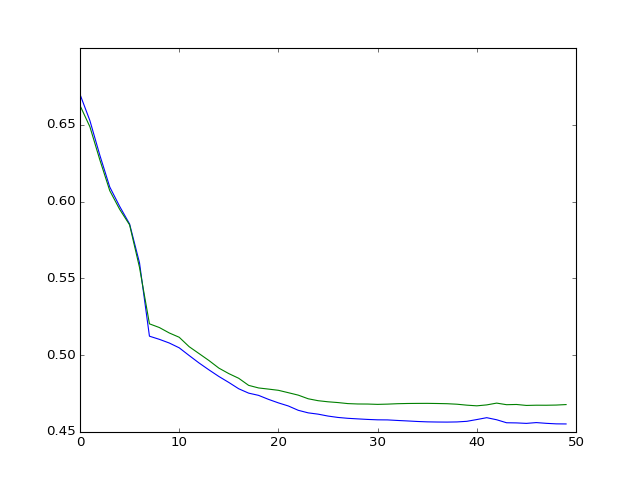

emp loss = 0.661835071791
val loss =  0.467859476805


In [23]:


# best settings:
#model = RNN(rnn_type ='GRU', nf=2, nh=25, nlay=3, dropout = 0.5)
#model = RNN(rnn_type ='GRU', nf=2, nh=10, nlay=1, dropout = 0.1) # BEST!! final test loss = 0.48
#model = RNN(rnn_type ='LSTM', nf=2, nh=16, nlay=1, dropout = 0.0) # 0.47 !

model = RNN(rnn_type ='GRU', nf=2, nh=20, nlay=3, dropout = 0.0) # best for diff_data !!! use Adam lr = 5e-4



#loss_fn = nn.MSELoss(size_average=True)
loss_fn = nn.BCELoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#optimizer = optim.Adagrad(model.parameters(), lr = 0.1)
#optimizer = optim.Adam(model.parameters(), lr = 0.7)
#optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
model.zero_grad()

def gen(x):
    threshold = 0.5
    if x[5] == 1:
        threshold += 0.5
    if x[0] == 1:
        threshold -= 0.25
    if (np.random.rand() > threshold):
        return 0
    else:
        return 1
    
def jump(x):
    return 1*(x[1] - x[0] > 0)
        

lag = 7

#var_x, var_y, lengths, xtest, ytest, test_lens = make_seq_data(jump, 2, 25, 1000, 1, fill='rand', gpu = True, xhot = False)
var_x, var_y, lengths, xtest, ytest, test_lens = make_seq_data(gen, lag, 100, 1000, 1, minlen=1, fill= 'rand', gpu = True, xhot = True)

#var_x, var_y, lengths, xtest, ytest, test_lens = make_diff_data(15, 1000, 1, 3, gpu = True)

#var_x, var_y, lengths, xtest, ytest, test_lens = make_r2rt_data(30, 1000, 1, gpu = True, xhot = True)
## manually run model a few iterations 
model.cuda()

bsiz = 100 # mini-batch size
nb = var_x.size()[1]/bsiz  # how many mini-batches per epoch

nepochs = 50
loss = 1.0
#epoch_range = trange(nepochs, desc='Loss', leave=True)
    
points = np.zeros(nepochs) # train losses
val_points = np.zeros(nepochs) # validation losses

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for p in model.parameters():
    if p.ndimension() < 2:
        nn.init.normal(p)
    else:
        nn.init.xavier_uniform(p)
    
for epoch in range(nepochs):
    for batch in range(nb):
        bStart = batch * bsiz
        bEnd = min(var_x.size()[1], (batch + 1)*bsiz)
        
        hidden = model.init_hidden(bsiz)
        hidden = repackage_hidden(hidden)
        
        model.zero_grad()
        optimizer.zero_grad()
        

        batch_x = var_x[:, bStart : bEnd, :]
        batch_lengths = lengths[bStart : bEnd]
        batch_x_packed = rnn_utils.pack_padded_sequence(Variable(batch_x), batch_lengths)
        y_pred, hidden = model(batch_x_packed, hidden)
                
        batch_y = rnn_utils.pack_padded_sequence(Variable(var_y[:, bStart : bEnd, :]), batch_lengths)
        

        # CAUTION -- y_pred is BATCH-WISE, i.e. b
        # batch 0 for ALL sequences, then
        # batch 2 for ALL sequences, etc.
        # target = var_y.squeeze()[:, bStart:bEnd].contiguous().view(-1, 1)
        loss = loss_fn(y_pred, batch_y.data)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # tqdm.write('loss = ' + str(loss.data[0]))
    points[epoch] = loss.data[0]    
    val_loss = loss_fn(model(Variable(xtest), None)[0], Variable(ytest)).data[0]
    val_points[epoch] = val_loss
    ax.clear()
    ax.plot(points)
    ax.plot(val_points)
    fig.canvas.draw()
#     epoch_range.set_description("Loss %4.3f" % loss.data[0])
#     epoch_range.refresh() # to show immediately the update


p = (ytest.sum()/(ytest*0 + 1).sum())
emp_loss = -p*np.log(p)-(1-p)*np.log(1-p)

print 'emp loss =', emp_loss
print 'val loss = ', val_loss


# print 'y,pred = ', zip(batch_y.data.squeeze()[:ny].data.cpu().numpy(), y_pred.data.squeeze()[:ny].cpu().numpy())


In [5]:
(ytest.sum()/(ytest*0 + 1).sum())

0.628125

In [ ]:
var_x[:15,0,0]


In [ ]:
var_y[:15, 0,0]
